## Подготовка

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor

In [2]:
# прочитаем файл таким образом, чтобы столбец с датой был индексом и имел тип datetime
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
# отсоортируем индексы таблицы
data = data.sort_index()

In [5]:
# проверим, в хронологическом ли порядке расположены даты и время
data.index.is_monotonic

True

In [6]:
data.index.min(), data.index.max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:50:00'))

У нас имеются данные с начала марта 2018 года по конец августа 2018 года. Даты и время расположены в хронологическом порядке, с интервалом в 10 мин. Необходимо изменить интервал на 1 час.

In [7]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [8]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


### Вывод

Данные были загружены и приведены к надлежащему типу, была проведена проверка на хронологию и был изменен интервал на 1 час.

## Анализ

<AxesSubplot:xlabel='datetime'>

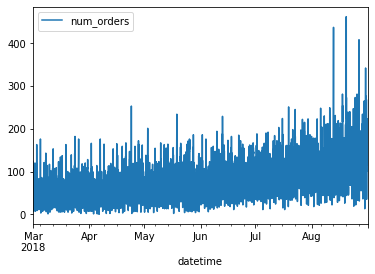

In [9]:
data.plot()

### Скользящее среднее

Text(0.5, 1.0, 'График скользящего среднего с размером окна 10')

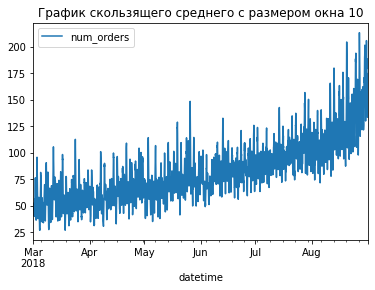

In [10]:
# снизим колебания временного ряда с помощью скользящего среднего
data.rolling(10).mean().plot()
plt.title('График скользящего среднего с размером окна 10')

Text(0.5, 1.0, 'График скользящего среднего с размером окна 100')

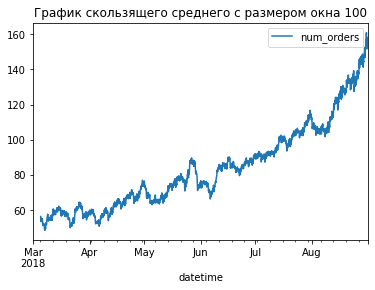

In [11]:
data.rolling(100).mean().plot()
plt.title('График скользящего среднего с размером окна 100')

### Тренды и сезонность

In [12]:
# посмотрим на тренды и сезонность
decomposed = seasonal_decompose(data)

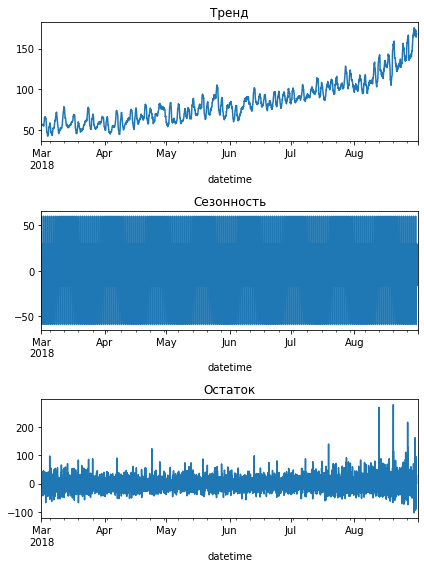

In [13]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

Наблюдается тенденция увеличения числа заказов с каждым месяцем. Сезонность необходимо рассмотреть более подробно.

Text(0.5, 1.0, 'График сезонности за месяц')

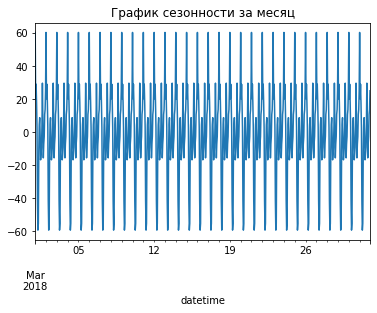

In [14]:
decomposed.seasonal['2018-03-01':'2018-03-31'].plot()
plt.title('График сезонности за месяц')

Text(0.5, 1.0, 'График сезонности за две недели')

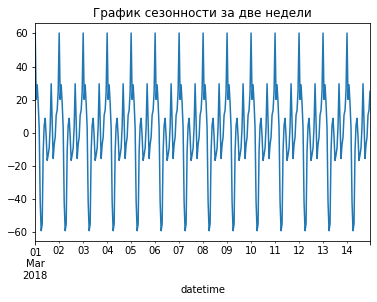

In [15]:
decomposed.seasonal['2018-03-01':'2018-03-14'].plot()
plt.title('График сезонности за две недели')

Text(0.5, 1.0, 'График сезонности за сутки 1.03')

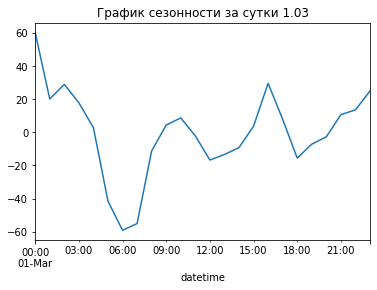

In [16]:
decomposed.seasonal['2018-03-01':'2018-03-01'].plot()
plt.title('График сезонности за сутки 1.03')

Text(0.5, 1.0, 'График сезонности за сутки 14.08')

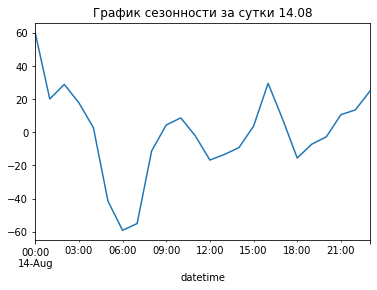

In [17]:
decomposed.seasonal['2018-08-14':'2018-08-14'].plot()
plt.title('График сезонности за сутки 14.08')

Сезонность наблюдается в течение суток. Увеличение числа заказов происходит после 6 часов утра и после 18 часов вечера, а также в обеденное время с 12 часов дня. Пики приходятся на 00 часов, 2 часа ночи, 10 часов утра, 16 часов дня, далее следуют спады.

### Исследование стационарности ряда

<AxesSubplot:xlabel='datetime'>

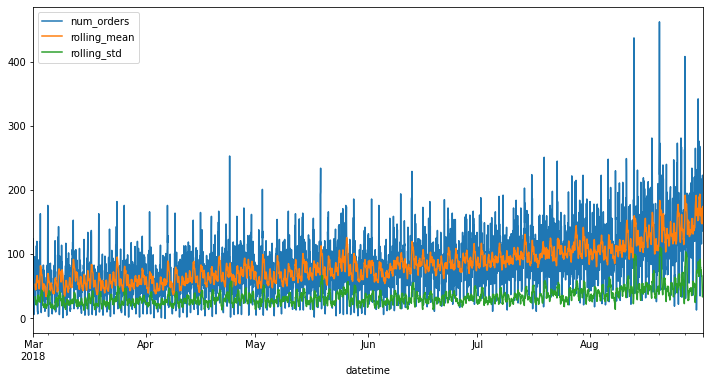

In [18]:
data['rolling_mean'] = data['num_orders'].rolling(15).mean()
data['rolling_std'] = data['num_orders'].rolling(15).std()
data.plot(figsize=(12, 6))

In [19]:
data = data.drop(['rolling_std', 'rolling_mean'], axis=1)
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [20]:
# проверим наш ряд на стационарность тестом Дики Фуллера
series = data['num_orders']
test = adfuller(series)
# p-value в тесте выводится вторым, значит имеет индекс 1
if test[1] < 0.05:
    print('Ряд стационарный')
else:
    print('Ряд нестационарный')

Ряд стационарный


### Вывод

В исследуемом ряду наблюдается тренд на увеличение заказов от месяца к месяцу. Также имеется суточная сезонность: утром и вечером число заказов растет, а ночью падает. Ряд стационарный, поэтому его можно прогнозировать.

## Обучение

### Подготовка признаков

In [21]:
# напишем функцию для создания признаков
def make_features(data, max_lag, rolling_mean_size):
    new_data = data.copy()
    new_data['year'] = new_data.index.year
    new_data['month'] = new_data.index.month
    new_data['day'] = new_data.index.day
    new_data['dayofweek'] = new_data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)

    new_data['rolling_mean'] = new_data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return new_data

In [22]:
# создадим новый датасет с признаками
new_data = make_features(data, 24, 20)
new_data.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# исходный датасет остался в переменной data
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [24]:
# разделим данные на выборки, тестовая часть должна составлять 10 процентов от всего датасета
train, test = train_test_split(new_data, shuffle = False, random_state = 12345, test_size = 0.2)
valid, test = train_test_split(test, shuffle = False, random_state = 12345, test_size = 0.5)

In [25]:
# удалим пропуски в первых значениях обучающей выборки
train = train.dropna()

In [26]:
features_train, features_valid, features_test = (train.drop('num_orders', axis=1),
                                                valid.drop('num_orders', axis=1), 
                                                test.drop('num_orders', axis=1))


target_train, target_valid, target_test = (train['num_orders'],
                                          valid['num_orders'],
                                          test['num_orders'])


print(features_train.shape, features_valid.shape, features_test.shape)
features_train.index.is_monotonic, features_valid.index.is_monotonic, features_test.index.is_monotonic

(3508, 29) (442, 29) (442, 29)


(True, True, True)

### Линейная регрессия

In [27]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
predictions_lr = model_lr.predict(features_valid)
rmse_lr = mean_squared_error(target_valid, predictions_lr, squared=False)
print('RMSE Линейной регрессии:', rmse_lr)

RMSE Линейной регрессии: 34.067570373060725


### Случайный лес

In [28]:
# при подборе параметров модели будем использовать специальную кроссвалидацию
# для временных рядов
tscv = TimeSeriesSplit(n_splits=3)

In [29]:
%%time

model_rf = RandomForestRegressor()
parametrs = {'n_estimators': [1, 100], 'max_depth': [1, 15]}
grid_rf = GridSearchCV(model_rf, parametrs, cv=tscv)
grid_rf.fit(features_train, target_train)
grid_rf.best_params_

CPU times: user 12 s, sys: 61.2 ms, total: 12.1 s
Wall time: 12.1 s


{'max_depth': 15, 'n_estimators': 100}

In [30]:
# инициализируем модель с наилучшими гиперпараметрами
model_rf = RandomForestRegressor(random_state=12345, n_estimators = 100, max_depth = 15)
model_rf.fit(features_train, target_train)
predictions_rf = model_rf.predict(features_valid)
rmse_rf = mean_squared_error(target_valid, predictions_rf, squared=False)
print('RMSE модели Случайный лес:', rmse_rf)

RMSE модели Случайный лес: 33.06392513733966


### CatBoost

In [31]:
%%time

model_cat = CatBoostRegressor(loss_function="RMSE")

parametrs = {'iterations': [50],
             'depth': [5, 10],
             'learning_rate': [0.1, 1]}

grid_cat = model_cat.grid_search(parametrs, features_train, target_train, cv=tscv,
                                 verbose=10, plot=False)

0:	learn: 70.1748907	test: 95.5852400	best: 95.5852400 (0)	total: 51.3ms	remaining: 2.51s
1:	learn: 64.6882325	test: 89.1964008	best: 89.1964008 (1)	total: 55ms	remaining: 1.32s
2:	learn: 59.5368884	test: 83.2461306	best: 83.2461306 (2)	total: 58.3ms	remaining: 913ms
3:	learn: 54.9001930	test: 77.7449296	best: 77.7449296 (3)	total: 61.5ms	remaining: 707ms
4:	learn: 50.7192900	test: 72.5298636	best: 72.5298636 (4)	total: 64.5ms	remaining: 581ms
5:	learn: 47.0514249	test: 68.1430681	best: 68.1430681 (5)	total: 67.6ms	remaining: 495ms
6:	learn: 43.8675402	test: 64.3176977	best: 64.3176977 (6)	total: 71.9ms	remaining: 442ms
7:	learn: 40.8908159	test: 60.2192273	best: 60.2192273 (7)	total: 75.3ms	remaining: 396ms
8:	learn: 38.3342028	test: 56.8763343	best: 56.8763343 (8)	total: 80ms	remaining: 365ms
9:	learn: 36.1040702	test: 53.9750544	best: 53.9750544 (9)	total: 86ms	remaining: 344ms
10:	learn: 34.1317479	test: 51.0236864	best: 51.0236864 (10)	total: 91ms	remaining: 323ms
11:	learn: 32.39

In [32]:
grid_cat['params']

{'depth': 5, 'iterations': 50, 'learning_rate': 0.1}

In [33]:
model_cat = CatBoostRegressor(loss_function="RMSE", depth=5, iterations=50, learning_rate=0.1)
model_cat.fit(features_train, target_train, verbose=10) 

0:	learn: 34.1812595	total: 3.54ms	remaining: 173ms
10:	learn: 26.3601084	total: 36.5ms	remaining: 129ms
20:	learn: 23.7824114	total: 76.5ms	remaining: 106ms
30:	learn: 22.7276957	total: 109ms	remaining: 66.6ms
40:	learn: 22.0567394	total: 160ms	remaining: 35.2ms
49:	learn: 21.6252992	total: 189ms	remaining: 0us


In [34]:
predictions_cat = model_cat.predict(features_valid)
rmse_cat = mean_squared_error(target_valid, predictions_cat, squared=False)
print('RMSE модели CatBoost:', rmse_cat)

RMSE модели CatBoost: 35.92180570126945


### Вывод

Были обучены и проверены на валидационной выборке несколько моделей. При проверке на валидационной выборке все модели прошли пороговые значения метрики RMSE не больше 48.

## Тестирование

In [35]:
pred_test_lr = model_lr.predict(features_test)
rmse_test_lr = mean_squared_error(target_test, pred_test_lr, squared=False)
print('RMSE Линейной регрессии на тестовой выборке:', rmse_test_lr)

RMSE Линейной регрессии на тестовой выборке: 46.11407885308614


In [36]:
pred_test_rf = model_rf.predict(features_test)
rmse_test_rf = mean_squared_error(target_test, pred_test_rf, squared=False)
print('RMSE модели Случайный лес на тестовой выборке:', rmse_test_rf)

RMSE модели Случайный лес на тестовой выборке: 50.53481226602903


In [37]:
pred_test_cat = model_cat.predict(features_test)
rmse_test_cat = mean_squared_error(target_test, pred_test_cat, squared=False)
print('RMSE модели CatBoost на тестовой выборке:', rmse_test_cat)

RMSE модели CatBoost на тестовой выборке: 55.44891582296288


<AxesSubplot:xlabel='datetime'>

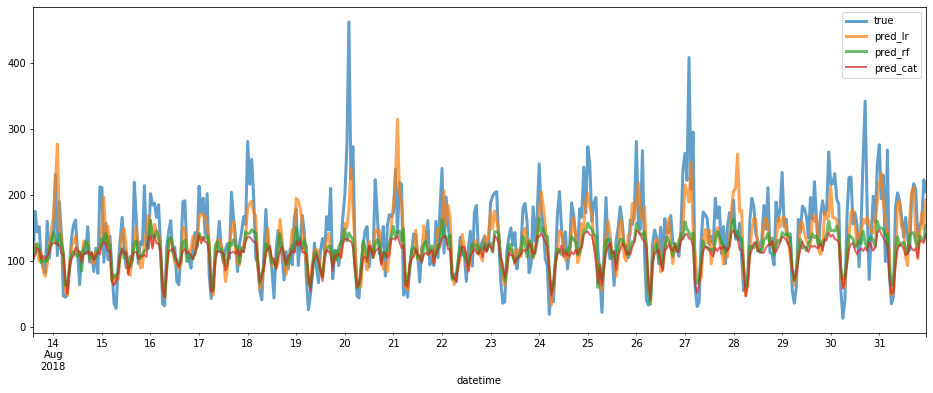

In [38]:
plt.figure()
target_test.plot(figsize=(16, 6), alpha=0.7, legend=True, linewidth=3, label='true')
pd.Series(pred_test_lr, index=target_test.index).plot(figsize=(16, 6), alpha=0.7, legend=True, linewidth=3, label='pred_lr')
pd.Series(pred_test_rf, index=target_test.index).plot(figsize=(16, 6), alpha=0.7, legend=True, linewidth=3, label='pred_rf')
pd.Series(pred_test_cat, index=target_test.index).plot(figsize=(16, 6), alpha=0.7, legend=True, linewidth=2, label='pred_cat')

При проверке качества модели на тестовой выборке проходной результат показала только модель Линейная регрессия.